# Import necessary libraries

In [30]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess CIFAR10 dataset

In [18]:
tf.keras.backend.image_data_format = 'channels_last'
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [3]:
fly = [0, 2]  # airplane, bird (it includes chickens but filtering those out is very inefficient)
no_fly = [1, 3, 4, 5, 6, 7, 8, 9]  # automobile, cat, deer, dog, frog, horse, ship, truck

In [17]:
def normalize_imgs(imgs):
    return (imgs - imgs.mean()) / (imgs.std() + 1e-8)

def convert_labels(labels):
    return np.where(np.isin(labels, fly), 1, 0)

In [10]:
train_labels_binary = convert_labels(train_labels)
test_labels_binary = convert_labels(test_labels)


train_images, test_images = normalize_imgs(train_images), normalize_imgs(test_images)


model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(1, activation='sigmoid')
])



In [11]:
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.01, weight_decay=0.05),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels_binary, epochs=30,
                    validation_data=(test_images, test_labels_binary))

test_predictions = model.predict(test_images)
test_predictions_binary = (test_predictions > 0.5).astype(int)

Epoch 1/30
1563/1563 [==============================] - 207s 132ms/step - loss: 0.4540 - accuracy: 0.8014 - val_loss: 0.3678 - val_accuracy: 0.8499
Epoch 2/30
1563/1563 [==============================] - 163s 104ms/step - loss: 0.3581 - accuracy: 0.8501 - val_loss: 0.3337 - val_accuracy: 0.8634
Epoch 3/30
1563/1563 [==============================] - 287s 184ms/step - loss: 0.3293 - accuracy: 0.8635 - val_loss: 0.3164 - val_accuracy: 0.8694
Epoch 4/30
1563/1563 [==============================] - 289s 185ms/step - loss: 0.3108 - accuracy: 0.8720 - val_loss: 0.2790 - val_accuracy: 0.8879
Epoch 5/30
1563/1563 [==============================] - 324s 207ms/step - loss: 0.2967 - accuracy: 0.8800 - val_loss: 0.2746 - val_accuracy: 0.8882
Epoch 6/30
1563/1563 [==============================] - 276s 176ms/step - loss: 0.2858 - accuracy: 0.8844 - val_loss: 0.2988 - val_accuracy: 0.8844
Epoch 7/30
1563/1563 [==============================] - 191s 122ms/step - loss: 0.2729 - accuracy: 0.8895 - val_

In [28]:
def plot_loss(history):
    """
    history: history object returned by keras fit method
    """
    plt.figure()
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Train', 'Validation'])
    plt.show()

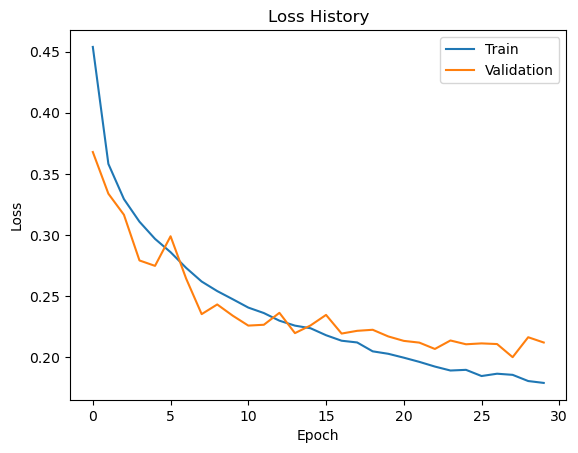

In [29]:
plot_loss(history)

Training loss looks like it can lower more! Validation loss looks like it has stagnated around a value.

# Confusion matrix

In [14]:
precision = precision_score(test_labels_binary, test_predictions_binary)
recall = recall_score(test_labels_binary, test_predictions_binary)
f1 = f1_score(test_labels_binary, test_predictions_binary)
accuracy = accuracy_score(test_labels_binary, test_predictions_binary)
conf_matrix = confusion_matrix(test_labels_binary, test_predictions_binary, normalize='true')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.8792359827479975
Recall: 0.7135
F1 Score: 0.7877449627380624
Accuracy: 0.9231


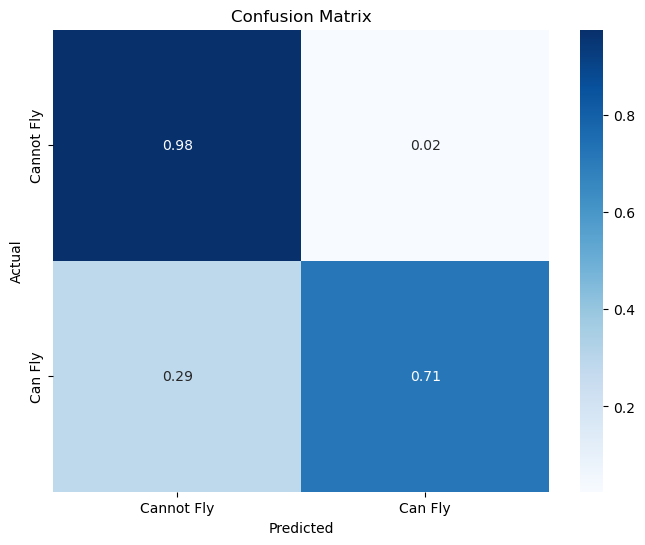

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Cannot Fly', 'Can Fly'], yticklabels=['Cannot Fly', 'Can Fly'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

The issue with judging what can fly as non-flyer is most likely due to our imbalanced dataset. the model knows more about what can't fly than it knows about what can fly.

In [15]:
# saving the model to disk so I don't have to train it every time
model.save_weights('model_weights.h5')

with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

# Test the model

In [24]:
from tensorflow.keras.models import model_from_json


with open('model_architecture.json', 'r') as f:
    model = model_from_json(f.read())


model.load_weights('model_weights.h5')

In [41]:
from tensorflow.keras.preprocessing import image
def predict_single_image(img_path, model):
    img = image.load_img(img_path, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = normalize_imgs(np.expand_dims(img_array, axis=0))
    prediction = model.predict(img_array)
    label = 'Can Fly' if prediction > 0.5 else 'Cannot Fly'
    plt.imshow(img)
    plt.title(f'Prediction: {label} with {np.round(prediction*100, 3)}% confidence')
    plt.axis('off')
    plt.show()

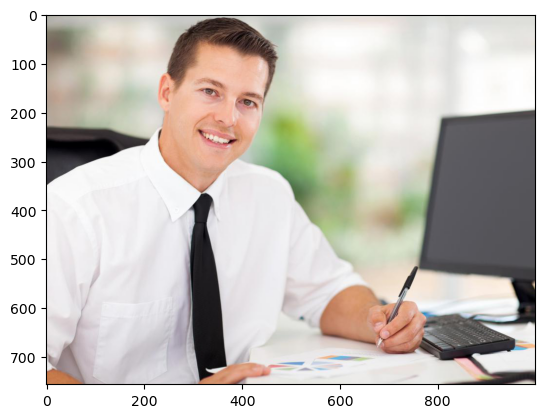

In [42]:
img_path = 'human.jpg'
img = mpimg.imread(img_path)
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 49ms/step


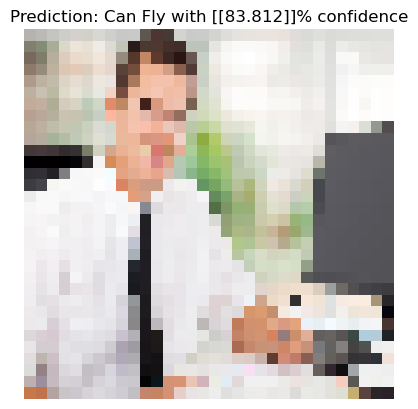

In [43]:
img_path = 'human.jpg'

predict_single_image(img_path, model)

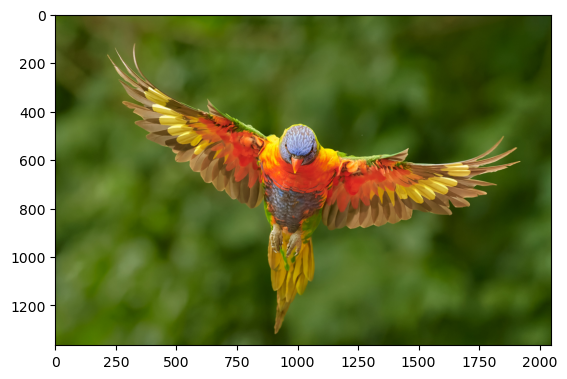

In [44]:
img_path = 'birb.jpg'
img = mpimg.imread(img_path)
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 28ms/step


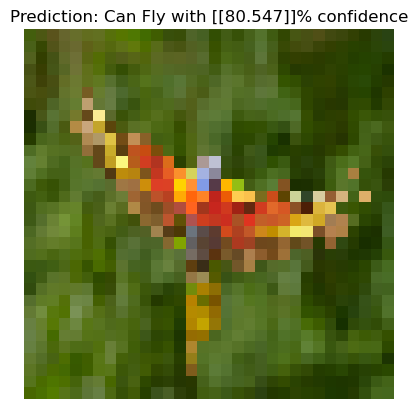

In [45]:
img_path = 'birb.jpg'
predict_single_image(img_path, model)

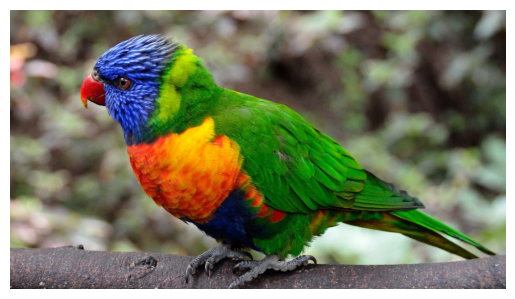

In [46]:
img_path = 'birb0.jpg'
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 25ms/step


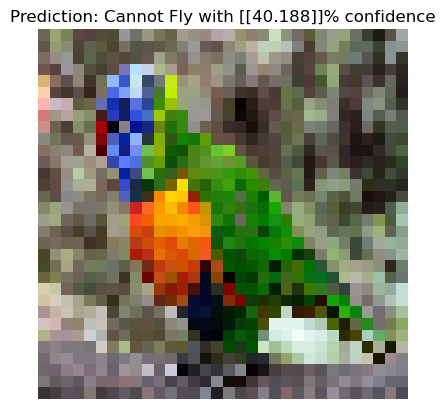

In [47]:
img_path = 'birb0.jpg'
predict_single_image(img_path, model)

- Image size is a huge factor here, since the 'squishification' is messing up with the image too much.
- the training data probably didn't include animals this colorful / humans in offices
- Trial and error with Dropout, learning rate ... (hyperparamters) + Architecture changes should be considered
- We can think of preprocessing images differently too!

> There's a LOT of room for improvement, which I guess is good and bad news, but mostly good news!

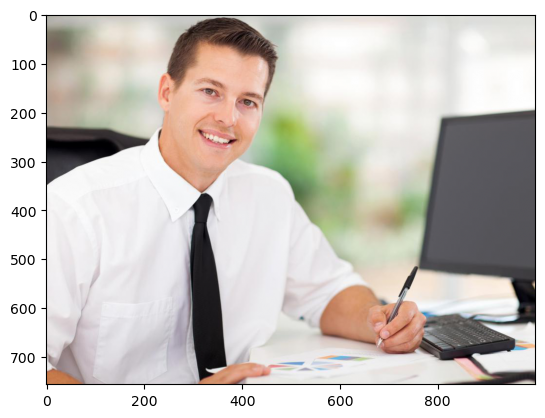

In [54]:
img_path = 'human.jpg'
img = mpimg.imread(img_path) /1
plt.imshow(img)
plt.show()